# Setup
Importing Data, dropping unneccessary columns to see the structure of the data better 

In [26]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error



import ast
import seaborn as sns
from plotnine import *

In [27]:
# Import the prewritten helper functions
# We are only using the color palette in this notebook
from py_helper_functions import *

In [28]:
listings = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-3/main/assignment-2/data/listings.csv')

In [29]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23185 entries, 0 to 23184
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23185 non-null  int64  
 1   listing_url                                   23185 non-null  object 
 2   scrape_id                                     23185 non-null  int64  
 3   last_scraped                                  23185 non-null  object 
 4   source                                        23185 non-null  object 
 5   name                                          23185 non-null  object 
 6   description                                   22822 non-null  object 
 7   neighborhood_overview                         13256 non-null  object 
 8   picture_url                                   23185 non-null  object 
 9   host_id                                       23185 non-null 

In [30]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [31]:
# drop some unnecessary columns
# these are mainly NAs,empty lists, urls, ids, or simpy variables that are just non relevant for the analysis
drop = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url',
                                  'host_name','host_since','host_location','host_about','host_thumbnail_url','host_picture_url','calendar_updated','calendar_last_scraped',
                                  'first_review','last_review','neighbourhood_group_cleansed','bathrooms','license','host_verifications','host_neighbourhood','has_availability',
                                  'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','availability_30','availability_60','availability_90',"host_response_time",
                                  "host_response_rate","host_acceptance_rate","host_is_superhost","host_listings_count","host_total_listings_count",]

listings = listings.drop(columns=drop)

In [32]:
listings.shape

(23185, 33)

# Cleaning the Data

## Cleaning numeric columns

In [33]:
# format binary variables
for binary in [
    "host_has_profile_pic",
    "host_identity_verified",
]:
    listings[binary] = listings[binary].map({"t": 1, "f": 0})


# formatting price column
listings['price'] = pd.to_numeric(listings['price'].replace('[\$,]', '', regex=True), errors='coerce')

# drop where price is missing
listings = listings.dropna(subset=['price'])

In [34]:
# look at these variables
listings[["host_has_profile_pic","host_identity_verified","instant_bookable","price"]].describe()

,host_has_profile_pic,host_identity_verified,price
count,23183.000000,23183.000000,23185.000000
mean,0.983307,0.896174,231.167134
std,0.128122,0.305041,1334.007349
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,95.000000
50%,1.000000,1.000000,149.000000
75%,1.000000,1.000000,226.000000
max,1.000000,1.000000,104983.000000


## Cleaning categorical/string columns

In [35]:
# Rename room type because it is too long
listings["room_type"] = listings["room_type"].map(
    {"Entire home/apt": "Entire",
        "Private room": "Private",
        "Shared room": "Shared"})

# check the distribution of room types
listings['room_type'].value_counts(dropna=False)

Entire     16887
Private     5932
Shared       277
NaN           89
Name: room_type, dtype: int64

In [36]:
# convert bathrooms_text to float
# def function to clean the bathroom text, split and space and set to int, if not possible set to 1
def clean_bathroom(text):
    try:
        return float(text.split(" ")[0])
    except:
        return text == 1 # the only missing was shared bath and Half-bath, which we can set to be 1

# apply function to the column
listings["bathrooms"] = listings["bathrooms_text"].apply(clean_bathroom)
listings.drop(columns="bathrooms_text", inplace=True)

# check the values
listings["bathrooms"].value_counts(dropna=False)

1.0     15054
2.0      4553
1.5      1557
2.5       937
3.0       436
3.5       238
0.0       159
4.0       121
4.5        28
5.0        21
8.0        21
5.5        20
7.5        13
6.0        10
8.5         6
11.0        3
6.5         3
7.0         2
9.5         2
9.0         1
Name: bathrooms, dtype: int64

In [37]:
# clean amenities column
# convert the amenities column to a list of amenities instead of a string
listings['new_amenities'] = listings['amenities'].apply(lambda x:ast.literal_eval(x)) # ast.literal_eval() to converts string to list so that way i can just get the values as a list

# create a list of all amenities
all_amentities = []

for list in listings['new_amenities']:
    for amenity in list:
        all_amentities.append(amenity)

# create a series of the 100 most frequent amenities
top100_amenities = pd.Series(all_amentities).value_counts().head(100)

# create a list of the top 100 amenities
amenities_list = top100_amenities.index.tolist()

# create a variable for each top 100 amenity + add a_ for amenity column
for my_amenities in amenities_list:
    listings["a_"+my_amenities] = listings['new_amenities'].apply(lambda x: 1 if my_amenities in x else 0)

# rename columns, as amenities can have spaces and uppercase characters
listings.columns = [name.replace(' ', '_').replace("–","").replace("-","").replace("’","").replace(":","").replace("/","_").lower() for name in listings.columns]

# drop the original amenities column
listings = listings.drop(columns=['amenities', 'new_amenities'])

In [38]:
# peak at the amenities
listings[listings.columns[listings.columns.str.startswith("a_")]].describe()


,a_kitchen,a_smoke_alarm,a_wifi,a_essentials,a_hangers,a_iron,a_hair_dryer,a_hot_water,a_dishes_and_silverware,a_shampoo,...,a_gas_stove,a_childrens_books_and_toys,a_ceiling_fan,a_shared_gym_in_building,a_pack_n_play_travel_crib,a_coffee_maker_nespresso,a_childrens_dinnerware,a_stainless_steel_oven,a_paid_parking_on_premises,a_mini_fridge
count,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,...,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000,23185.000000
mean,0.947380,0.935562,0.880009,0.866810,0.783438,0.750399,0.741557,0.698339,0.693595,0.670865,...,0.067716,0.066422,0.064438,0.064179,0.063834,0.062627,0.059737,0.059435,0.058702,0.058184
std,0.223279,0.245537,0.324958,0.339787,0.411911,0.432791,0.437788,0.458989,0.461010,0.469909,...,0.251264,0.249024,0.245537,0.245078,0.244463,0.242296,0.237004,0.236442,0.235071,0.234096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering

In [39]:
# where do we have missing variables?
to_filter = listings.isna().sum()
to_filter[to_filter > 0]

host_has_profile_pic              2
host_identity_verified            2
neighbourhood                  9928
room_type                        89
bedrooms                       6297
beds                            183
review_scores_rating           4510
review_scores_accuracy         4756
review_scores_cleanliness      4752
review_scores_checkin          4758
review_scores_communication    4753
review_scores_location         4758
review_scores_value            4758
reviews_per_month              4510
dtype: int64

In [40]:
# first create flags for missing variables, then input with median.

listings = listings.assign(
    # flag for beds
    flag_beds=np.multiply(listings.beds.isna(), 1),
    beds=listings.beds.fillna(np.median(listings.beds.dropna())),
    # flag for bathrooms
    flag_bathrooms=np.multiply(listings.bathrooms.isna(), 1),
    bathrooms=listings.bathrooms.fillna(np.median(listings.bathrooms.dropna())),
    # flag for cleaniness reviews
    flag_review_scores_cleanliness=np.multiply(listings.review_scores_cleanliness.isna(), 1),
    review_scores_cleanliness=listings.review_scores_cleanliness.fillna(
        np.median(listings.review_scores_cleanliness.dropna())),
    # flag for review score
    flag_review_scores_rating=np.multiply(listings.review_scores_rating.isna(), 1),
    review_scores_rating=listings.review_scores_rating.fillna(
        np.median(listings.review_scores_rating.dropna())),
    # flag for reviews per month
    flag_reviews_per_month=np.multiply(listings.reviews_per_month.isna(), 1),
    reviews_per_month=listings.reviews_per_month.fillna(
        np.median(listings.reviews_per_month.dropna())),
    # flag for number of reviews
    flag_number_of_reviews=np.multiply(listings.number_of_reviews.isna(), 1),
    number_of_reviews=listings.number_of_reviews.fillna(
        np.median(listings.number_of_reviews.dropna())),
    # flag for checkin reviews
    flag_review_scores_checkin=np.multiply(listings.review_scores_checkin.isna(), 1),
    review_scores_checkin=listings.review_scores_checkin.fillna(
        np.median(listings.review_scores_checkin.dropna())),
    # flag for communication reviews
    flag_review_scores_communication=np.multiply(listings.review_scores_communication.isna(), 1),
    review_scores_communication=listings.review_scores_communication.fillna(
        np.median(listings.review_scores_communication.dropna())),
    # flag for location reviews
    flag_review_scores_location=np.multiply(listings.review_scores_location.isna(), 1),
    review_scores_location=listings.review_scores_location.fillna(
        np.median(listings.review_scores_location.dropna())),
    # flag for value reviews
    flag_review_scores_value=np.multiply(listings.review_scores_value.isna(), 1),
    review_scores_value=listings.review_scores_value.fillna(
        np.median(listings.review_scores_value.dropna())),
    )

In [41]:
# filter based on property type, also rename them to a more general category
# define set of good property types, that fit the business needs
propertytypes = ["Entire rental unit",
                 "Private room in rental unit",
                 "Entire home",
                 "Entire condo",
                 "Private room in home",
                 "Apartment",
                 "House",
                 "Townhouse",
                 "Shared room in rental unit"]

# keep if property type is in the set
listings = listings.loc[lambda x: x["property_type"].isin(propertytypes)]

# rename to Rental unit or House
listings['property_type'] = listings['property_type'].apply(lambda x: 'Rental Unit' if "rental unit" in x else 'House')

In [42]:
# bedrooms
listings.bedrooms.value_counts(dropna=False)

2.0     5718
1.0     5027
NaN     4963
3.0     2053
4.0      872
5.0      243
6.0       76
7.0       21
10.0       4
9.0        3
11.0       3
8.0        3
14.0       3
Name: bedrooms, dtype: int64

In [43]:
before = listings.shape[0]
listings = listings.dropna(subset=['bedrooms'])
after = listings.shape[0]
print(f"Dropped {before-after} rows due to missing bedrooms")

Dropped 4963 rows due to missing bedrooms


In [44]:
## drop huge number of bathrooms
before = listings.shape[0]
listings=listings.loc[listings.bathrooms < 8]
after = listings.shape[0]
print(f"Dropped {before - after} rows with bathrooms < 8")

Dropped 18 rows with bathrooms < 8


In [45]:
listings.bathrooms.value_counts(dropna=False).reset_index().sort_values(by='index')

,index,bathrooms
10,0.0,7
0,1.0,8469
2,1.5,677
1,2.0,3682
3,2.5,624
4,3.0,291
5,3.5,165
6,4.0,44
7,4.5,22
8,5.0,9


In [46]:
# Pool accomodations with 0,1,2,10 bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 7)], closed="left")
f_bath = pd.cut(listings["bathrooms"].to_list(), bins, labels=["0", "1", "2"])
f_bath.categories = [0, 1, 2]
listings["bathrooms"] = f_bath

f_bath.value_counts(dropna=False)

0         7
1      9146
2      4853
NaN       2
dtype: int64

In [47]:
listings["room_type"].value_counts()

Entire     13883
Private      125
Name: room_type, dtype: int64

In [48]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(listings.minimum_nights))], closed="left"
)
f_min_n = pd.cut(listings["minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
listings["minimum_nights"] = f_min_n
listings["minimum_nights"].value_counts(dropna=False)

3      5103
2      5001
1      3903
NaN       1
Name: minimum_nights, dtype: int64

In [49]:
# Pool num of reviews to 3 categories: none, 1-51 and >51

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(listings.number_of_reviews))], closed="left"
)
fnor = pd.cut(listings["number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
listings["number_of_reviews"] = fnor
listings["number_of_reviews"].value_counts(dropna=False)

1      8990
2      2647
0      2370
NaN       1
Name: number_of_reviews, dtype: int64

In [50]:
listings['availability_365'].value_counts().sort_index()

0      3331
1        39
2        68
3        36
4        20
       ... 
361      43
362      53
363      60
364      63
365     161
Name: availability_365, Length: 366, dtype: int64

In [51]:
# Pool availability 365 to 4 categories: 1-51,51-151,151-251, >251

bins = pd.IntervalIndex.from_tuples(
    [(0, 51), (51, 151), (151, 251), (251, max(listings.availability_365))], closed="left"
)

fnor = pd.cut(listings["availability_365"].to_list(), bins, labels=["0", "1", "2", "3"])
fnor.categories = [0, 1, 2, 3]
listings["availability_365"] = fnor

listings["availability_365"].value_counts(dropna=False)

0      4673
1      3576
3      3506
2      2092
NaN     161
Name: availability_365, dtype: int64

In [52]:
listings.bedrooms.value_counts(dropna=False)

2.0     5718
1.0     5015
3.0     2053
4.0      872
5.0      243
6.0       76
7.0       21
9.0        3
8.0        3
11.0       2
14.0       1
10.0       1
Name: bedrooms, dtype: int64

In [53]:
listings.T

,1,2,4,5,6,9,10,11,12,13,...,23173,23174,23176,23177,23178,23179,23180,23181,23182,23183
id,12936,38271,43429,1181117,1188388,1192689,44082,1201338,1210073,1233439,...,971385848818575605,969280954896268255,971570547679229207,969308498306934752,971588505523400983,971599030604344292,971604763527045723,969314524632337156,971613881418926837,971616602219608699
host_has_profile_pic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
host_identity_verified,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
neighbourhood,"St Kilda, Victoria, Australia","Berwick, Victoria, Australia","Oakleigh East, Victoria, Australia","Ripponlea, Victoria, Australia","Port Melbourne, Victoria, Australia","St Kilda, Victoria, Australia","Frankston, Victoria, Australia","South Melbourne, Victoria, Australia",NaN,"Melbourne, Victoria, Australia",...,NaN,"Southbank, Victoria, Australia",NaN,"South Yarra, Victoria, Australia",NaN,"Melbourne, Victoria, Australia",NaN,NaN,NaN,NaN
neighbourhood_cleansed,Port Phillip,Casey,Monash,Port Phillip,Port Phillip,Port Phillip,Frankston,Port Phillip,Darebin,Stonnington,...,Melbourne,Melbourne,Melbourne,Stonnington,Melbourne,Port Phillip,Melbourne,Melbourne,Yarra,Whitehorse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_number_of_reviews,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
flag_review_scores_checkin,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_communication,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
flag_review_scores_location,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [54]:
for column in listings.columns:
    print(listings[column].value_counts(dropna=False))
    print(##################################################################
    )

12936                 1
766817912048480711    1
768605076805768701    1
768689686030733073    1
771456254109537745    1
                     ..
37865372              1
37539101              1
37539846              1
38006276              1
971616602219608699    1
Name: id, Length: 14008, dtype: int64

1.0    13769
0.0      239
Name: host_has_profile_pic, dtype: int64

1.0    12920
0.0     1088
Name: host_identity_verified, dtype: int64

NaN                                           5710
Melbourne, Victoria, Australia                1555
Southbank, Victoria, Australia                 695
South Yarra, Victoria, Australia               401
Carlton, Victoria, Australia                   299
                                              ... 
St kilda, Victoria, Australia                    1
Kooyong, Victoria, Australia                     1
Williams Landing, Australia                      1
Brunswick / Melbourne, Victoria, Australia       1
Seville, Victoria, Australia                     

# Exploratory Data Analysis

In [55]:
listings['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    14008.000000
mean       255.652199
std        965.091773
min         14.000000
25%        130.000000
50%        170.000000
75%        256.000000
90%        409.000000
95%        600.000000
99%       1248.530000
max      99999.000000
Name: price, dtype: float64

In [56]:
## drop unreasonable prices
before = listings.shape[0]
listings = listings[listings['price'] <= 400]
after = listings.shape[0]
print(f"Dropped {before - after} rows with price <= 400")

Dropped 1439 rows with price <= 400


Text(0, 0.5, 'Number of listings')

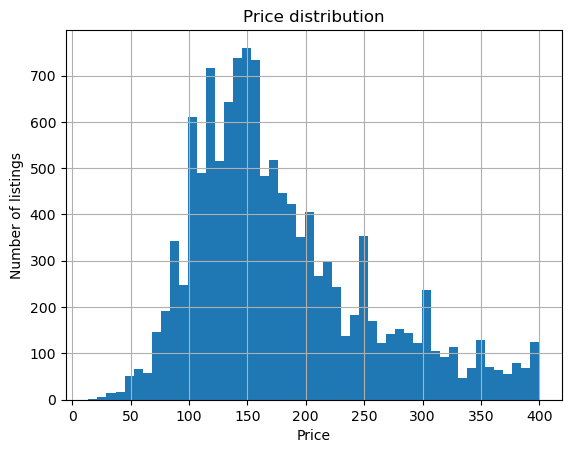

In [57]:
listings['price'].hist(bins = 50)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of listings')


Since our price distribution is skewed to the right, our Models going to have quite high RMSE values. If we were to filter for only lower valus of price, our RMSEs would decrase.

In [58]:
## drop huge number of accomodates
before = listings.shape[0]
listings=listings.loc[listings.accommodates < 7]
after = listings.shape[0]
print(f"Dropped {before - after} rows with accomodates < 7")

Dropped 1153 rows with accomodates < 7


In [59]:
before = listings.shape[0]
listings["beds"].value_counts(dropna=False)
listings = listings.loc[listings.beds > 0]
after = listings.shape[0]
print(f"Dropped {before - after} rows with beds > 0")

Dropped 0 rows with beds > 0


In [60]:
# we still have enough data to work with
listings.shape

(11416, 142)

In [61]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean))

,mean_price
accommodates,
1,99.588889
2,142.036240
3,147.186937
4,179.742456
5,197.241341
6,228.048811


<Axes: xlabel='accommodates'>

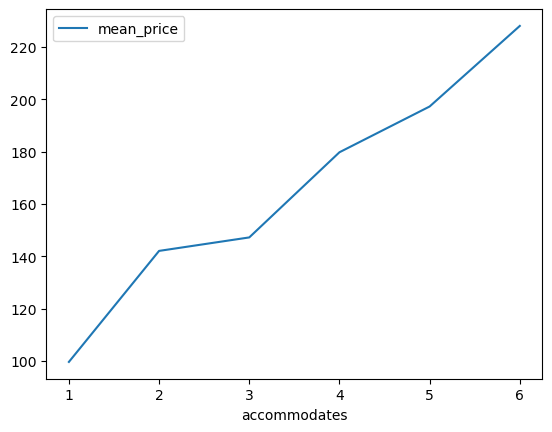

In [62]:
listings.groupby(["accommodates"]).agg(mean_price=("price", np.mean)).plot()

In [63]:
#How is the average price changing in my district by `property_type`, `room_type`?
listings.groupby(["property_type", "room_type"]).agg(mean_price=("price", np.mean))

mean_price
property_type room_type            
House         Entire     201.995868
              Private     77.309859
Rental Unit   Entire     164.682729
              Private    107.640000

<Axes: xlabel='availability_365'>

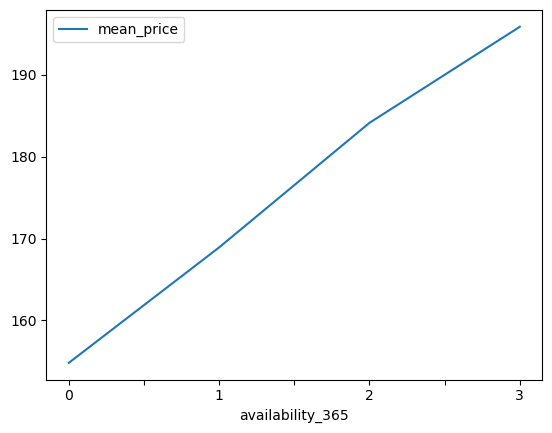

In [64]:
#What is the correlation between availability of the AirBnb and its Price?
listings.groupby("availability_365").agg(mean_price=("price", np.mean)).plot()

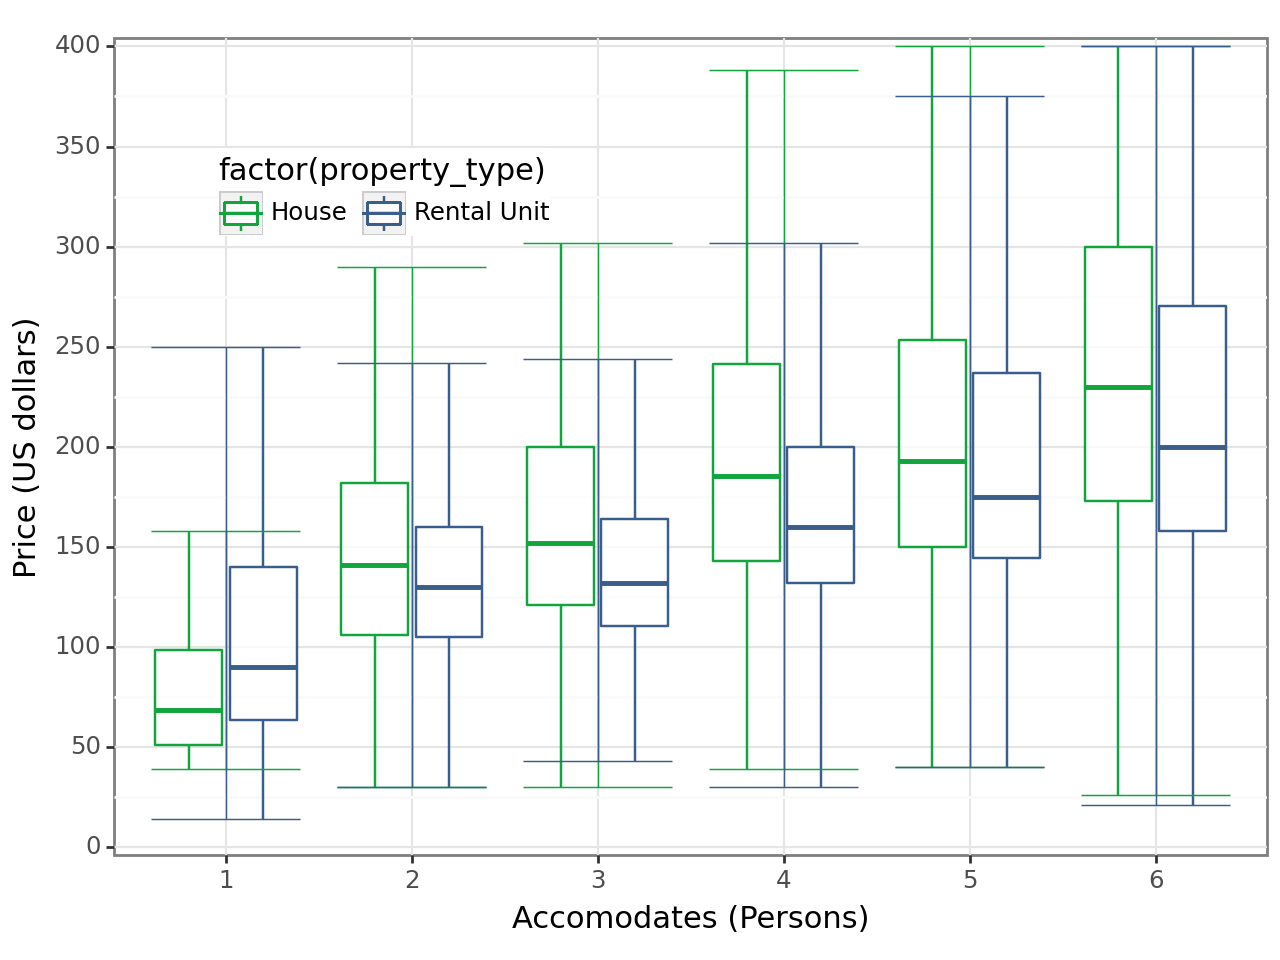

<Figure Size: (640 x 480)>

In [65]:
(
    ggplot(
        listings,
        aes(
            x="factor(accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

# Variable Selection

In [66]:
basic_lev = (
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms")

basic_add = ("bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365",
             "minimum_nights")

reviews = ("number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating")

more_reviews = ("review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value")

amenity_columns = tuple([col for col in listings.columns if col.startswith("a_")])

In [67]:
X1 = "room_type:property_type"
X2 = (" + a_pets_allowed:room_type", "a_bathtub:room_type")
X3 = "(property_type + beds + bedrooms + room_type + bathrooms):(" + "+".join(amenity_columns) + ")"

modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)+ "+" + "+".join(amenity_columns)
modellev8 = ("~"+ "+".join(basic_lev)+ "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+"+ "+".join(more_reviews)+ "+"+ X1+ "+"+ "+".join(X2)+ "+"+ "+".join(amenity_columns)+ "+"+ X3)


# LASSO Model for Interaction Selection:
Lasso is mainly used for feature selection, as it shrinks the coefficients of less important features to exactly 0.
This is useful for feature selection, as it can be used to remove less important features from the model.
Will also include lots of interactions so in the end we can see which interactions are important.

In [68]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import datetime

In [69]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
smp_size = round(0.2 * listings.shape[0])-1
y, X = patsy.dmatrices("price" + modellev8, listings) # use the most complex model

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [71]:
for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20240115)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-02-09 23:11:43


Run:  1, lambda: 0.10, start: 2024-02-09 23:14:36
Run:  2, lambda: 0.15, start: 2024-02-09 23:16:12
Run:  3, lambda: 0.20, start: 2024-02-09 23:17:34
Run:  4, lambda: 0.25, start: 2024-02-09 23:18:36
Run:  5, lambda: 0.30, start: 2024-02-09 23:19:24
Run:  6, lambda: 0.35, start: 2024-02-09 23:20:10
Run:  7, lambda: 0.40, start: 2024-02-09 23:20:53
Run:  8, lambda: 0.45, start: 2024-02-09 23:21:33
Run:  9, lambda: 0.50, start: 2024-02-09 23:22:15
Run: 10, lambda: 0.55, start: 2024-02-09 23:23:02
Run: 11, lambda: 0.60, start: 2024-02-09 23:23:55
Run: 12, lambda: 0.65, start: 2024-02-09 23:24:49
Run: 13, lambda: 0.70, start: 2024-02-09 23:25:49
Run: 14, lambda: 0.75, start: 2024-02-09 23:26:48
Run: 15, lambda: 0.80, start: 2024-02-09 23:27:44
Run: 16, lambda: 0.85, start: 2024-02-09 23:28:37
Run: 17, lambda: 0.90, start: 2024-02-09 23:29:23
Run: 18, lambda: 0.95, start: 2024-02-09 23:30:18


In [125]:
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [73]:
r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [74]:
r_squared_data

,lambda,variable,value
0,0.05,$R^2$ Test set,0.383656
1,0.10,$R^2$ Test set,0.390957
2,0.15,$R^2$ Test set,0.392804
3,0.20,$R^2$ Test set,0.393806
4,0.25,$R^2$ Test set,0.394967
5,0.30,$R^2$ Test set,0.395770
6,0.35,$R^2$ Test set,0.395792
7,0.40,$R^2$ Test set,0.395325
8,0.45,$R^2$ Test set,0.394635
9,0.50,$R^2$ Test set,0.393857


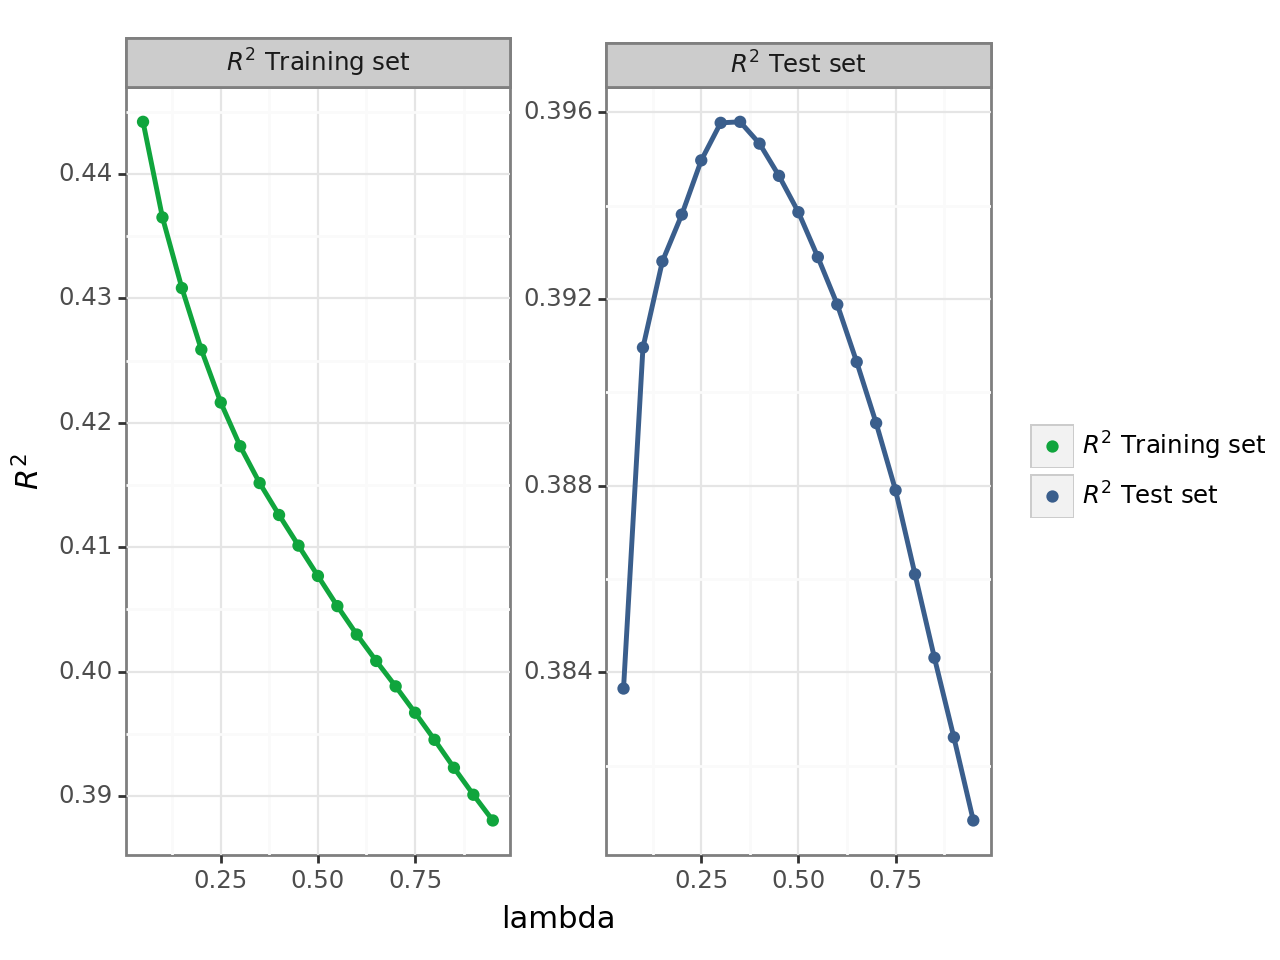

<Figure Size: (640 x 480)>

In [75]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_wrap("variable", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

In [76]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    39.579187
lambda        0.350000
Name: 6, dtype: float64

In [130]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.35)

In [135]:
coefficients = reg_best.coef_[reg_best.coef_>0]

# write the coefficients to a file so later we don't have to rerun the model
with open('coefficients.txt', 'w') as file:
    for feature, coefficient in zip(modellev8.split('+'), coefficients):
        file.write(f"{feature.strip()} = {coefficient}\n")

# print out the results
for feature, coefficient in zip(modellev8.split('+'), coefficients):
    print(f"{feature.strip()} = {coefficient}")


~accommodates = 0.2655980096173005
beds = 0.4021393538178447
flag_beds = 2.5345314575475952
property_type = 0.18789140323439052
room_type = 0.2192742117444626
bedrooms = 1.9838030427609412
bathrooms = 2.966471357126226
flag_bathrooms = 5.893000015607015
neighbourhood_cleansed = 4.10225847487179
availability_365 = 5.777980153816276
minimum_nights = 12.48217669564332
number_of_reviews = 1.5054044357560716
flag_number_of_reviews = 1.2657598800424916
reviews_per_month = 8.781865158027868
flag_reviews_per_month = 9.23752248372758
review_scores_rating = 2.102961188183517
flag_review_scores_rating = 6.708930834593002
review_scores_cleanliness = 1.5389438954679016
flag_review_scores_cleanliness = 0.37160378655383874
review_scores_checkin = 1.8113564853673656
flag_review_scores_checkin = 1.4952243586903549
review_scores_communication = 0.025473423999509734
flag_review_scores_communication = 1.2168211057937655
review_scores_location = 0.7048752363526191
flag_review_scores_location = 1.8814881110

In [79]:
# good interactions: room_type:property_type, a_pets_allowed:room_type, a_bathtub:room_type

## Lasso using GridSearchCV
now we already now the best interactions.

In [80]:
data_work,data_holdout=train_test_split(listings, test_size=smp_size)

In [81]:
X1 = "room_type:property_type"
X2 = (" + a_pets_allowed:room_type", "a_bathtub:room_type")
modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)+ "+" + "+".join(amenity_columns)

In [82]:
y,  X = patsy.dmatrices('price'+ modellev7, listings)

In [83]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)

In [84]:
print(" RMSE: " + str(results.best_score_ * -1))

 RMSE: 56.254903073226686


In [85]:
best_lasso_model = results.best_estimator_
print(best_lasso_model)

Lasso(alpha=0.05)


In [86]:
model7_level = smf.ols('price'+modellev7, data=data_work).fit(cov_type='HC0')

In [87]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [data_work["price"], model7_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)

model7_level_work_predictions.tail()

,price,predicted
11965,191.0,199.099154
19859,197.0,175.102182
5727,158.0,227.963612
1931,81.0,117.212892
4177,99.0,145.176748


In [88]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [89]:
model7_level_holdout_predictions = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:55.37 	 RMSE holdout:55.91


In [90]:
Ylev=data_holdout['price']
meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)

In [91]:
model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,209.989709,8.279126,193.762920,226.216499,99.307532,320.671887
1,129.940038,6.008221,118.164141,141.715935,19.822340,240.057736
2,168.910491,5.209049,158.700943,179.120039,58.949269,278.871714
3,183.167556,6.637881,170.157548,196.177564,72.911055,293.424057
4,199.128116,5.157730,189.019152,209.237080,89.176186,309.080046
...,...,...,...,...,...,...
2265,212.412160,5.263370,202.096145,222.728176,102.441001,322.383319
2266,287.098634,9.096349,269.270117,304.927151,176.170316,398.026951
2267,154.326056,3.943130,146.597664,162.054448,44.567395,264.084717
2268,168.602186,5.423015,157.973272,179.231101,58.601234,278.603138


In [92]:
# Create data frame with the real and predicted values
data_diagnostic = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [93]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
data_diagnostic["Ylev"] = df_["price"]

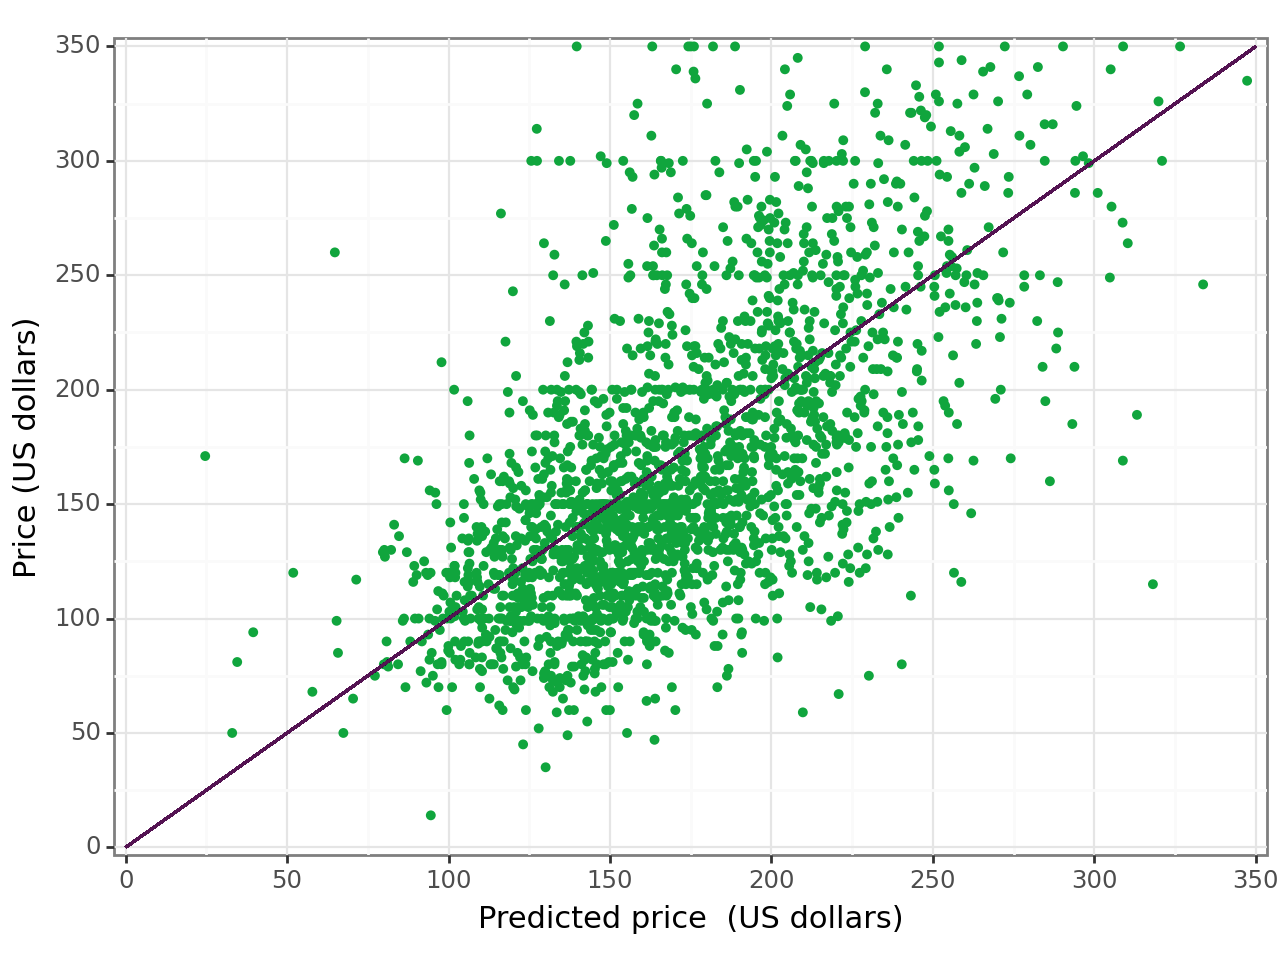

<Figure Size: (640 x 480)>

In [94]:
(
    ggplot(data=data_diagnostic)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[1],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(aes(x=0, y=0, xend=350, yend=350), size=0.5, color=color[2])
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)

# Interaction Visualization
This part visualizes those interactions that were found with Lasso

In [95]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

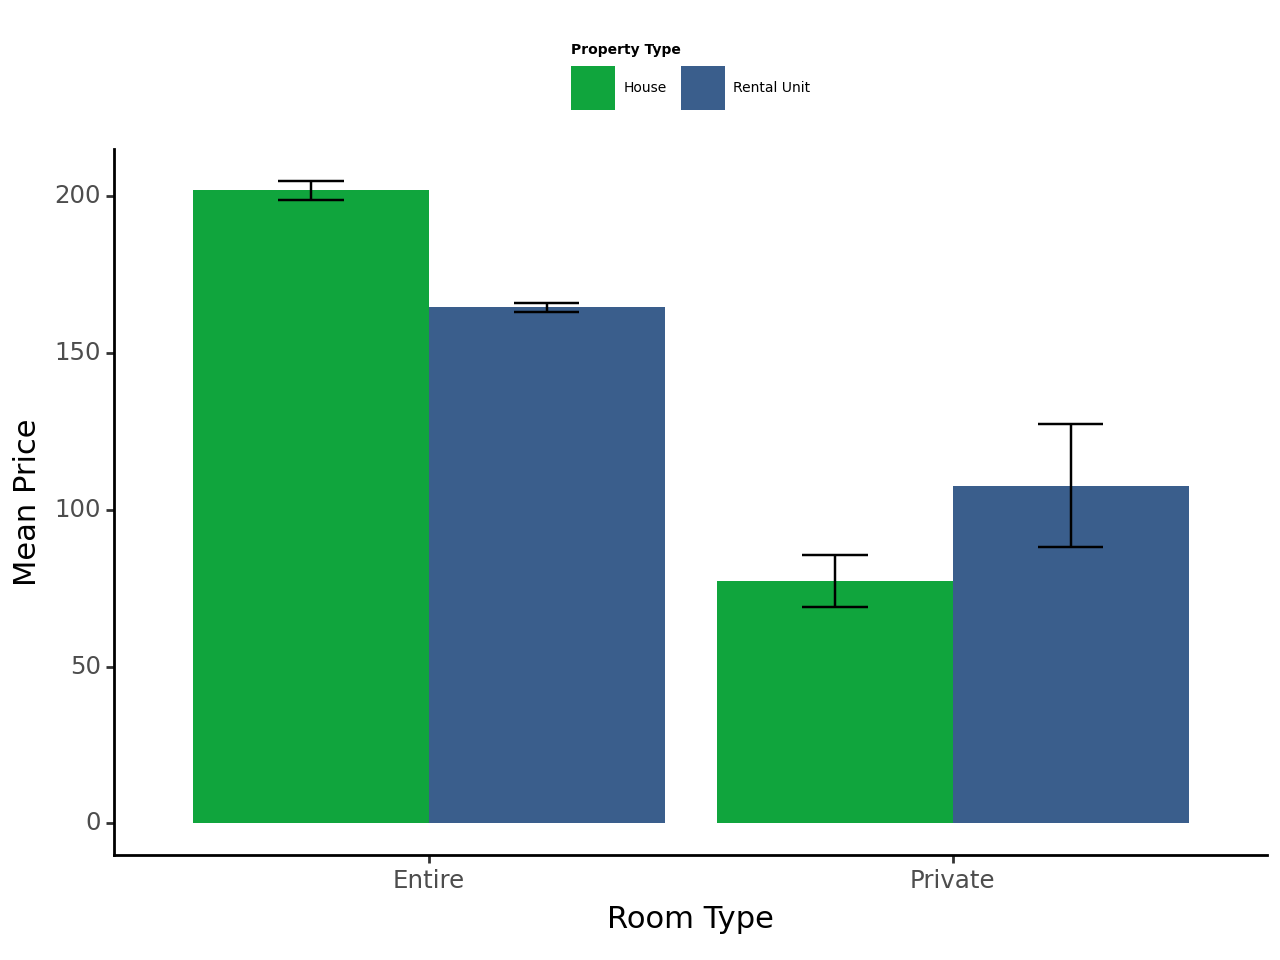

<Figure Size: (640 x 480)>

In [96]:
price_diff_by_variables(
    listings,
    "room_type",
    "property_type",
    "Room Type",
    "Property Type",
)

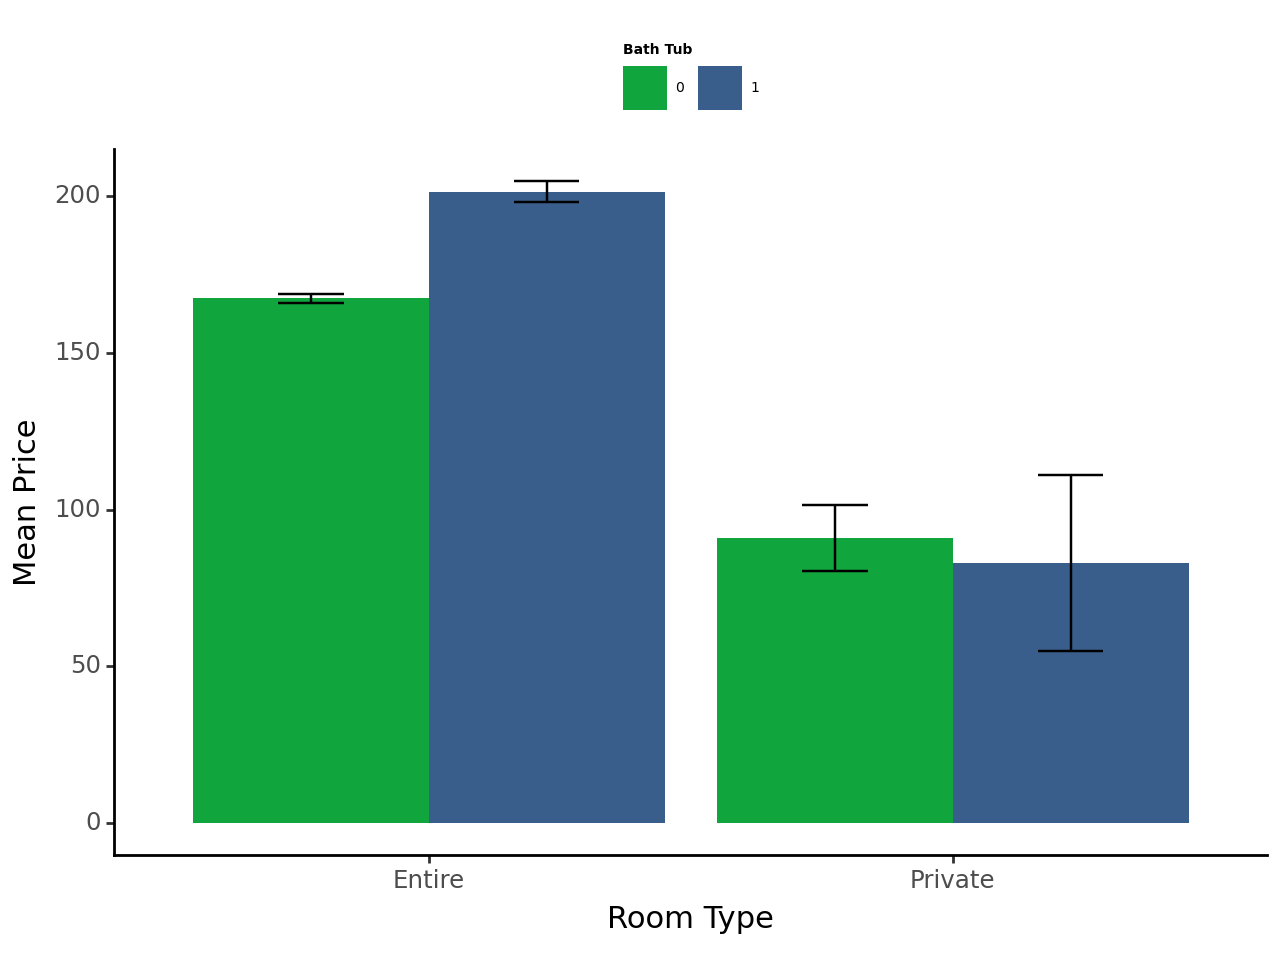

<Figure Size: (640 x 480)>

In [97]:
price_diff_by_variables(
    listings,
    "room_type",
    "a_bathtub",
    "Room Type",
    "Bath Tub",
)

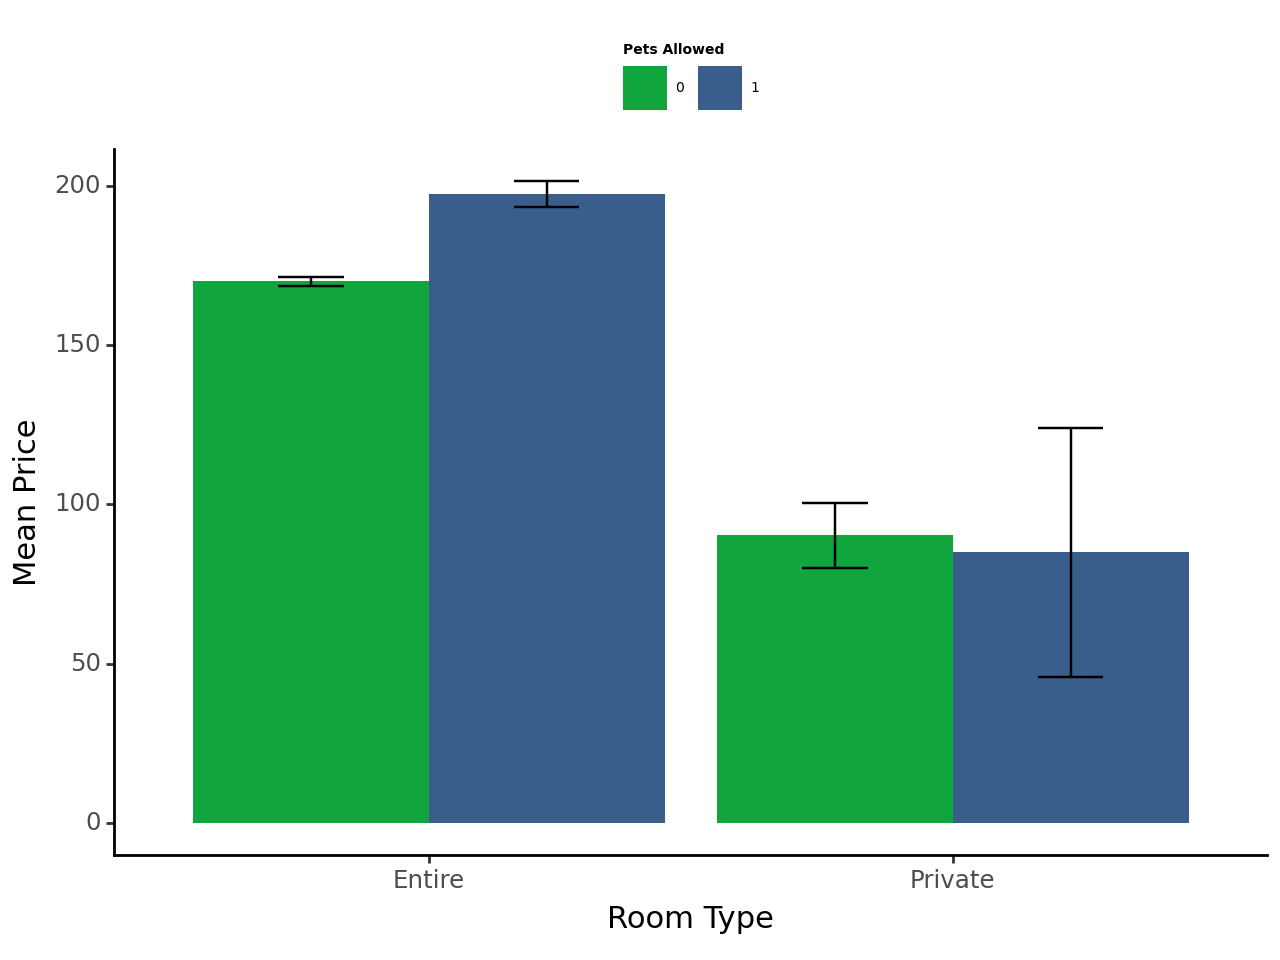

<Figure Size: (640 x 480)>

In [98]:
price_diff_by_variables(
    listings,
    "room_type",
    "a_pets_allowed",
    "Room Type",
    "Pets Allowed",
)

# OLS Model: Regression with Cross-Validation

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse

In [100]:
X1 = "room_type:property_type"
X2 = (" + a_pets_allowed:room_type", "a_bathtub:room_type")
modellev1 = "~ accommodates"
modellev2 = "~" + "+".join(basic_lev)
modellev3 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add)
modellev4 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)
modellev5 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1
modellev6 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)
modellev7 = "~" + "+".join(basic_lev) + "+" + "+".join(basic_add) + "+" + "+".join(reviews)+ "+" + "+".join(more_reviews)+ "+" + "+" + X1+"+"+"+".join(X2)+ "+" + "+".join(amenity_columns)

In [101]:
n_folds=5

# Set the seed to make results reproducable
np.random.seed(20240206)
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)


In [102]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [103]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7
]:
    cv_list += [cv_reg("price" + i, listings, k, "HC0")]

ols_cv = summarize_cv(cv_list)
ols_cv

,Model1,Model2,Model3,Model4,Model5,Model6,Model7
Fold1,64.899480,63.019852,58.982854,58.200083,57.757140,57.274653,54.774923
Fold2,65.442514,63.591983,59.407766,58.617170,58.249169,57.776624,55.457121
Fold3,65.266205,63.624287,59.258197,58.642015,58.195775,57.797132,55.495368
Fold4,64.206392,62.539480,58.043913,57.595930,57.109600,56.776314,54.504109
Fold5,66.399628,64.697655,60.071116,59.131401,58.450484,57.994548,55.422351
Average,65.242844,63.494652,59.152769,58.437320,57.952434,57.523854,55.130775


In [104]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 7):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 7):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [105]:
rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,65.242844,2
1,6,RMSE Training,63.494652,7
2,42,RMSE Training,59.152769,43
3,46,RMSE Training,58.437320,47
4,56,RMSE Training,57.952434,57
5,60,RMSE Training,57.523854,61
6,158,RMSE Training,55.130775,159
7,1,RMSE Test,65.683132,2
8,6,RMSE Test,64.056217,7
9,42,RMSE Test,60.138349,43


In [106]:
# best one:
rmse_levels[rmse_levels['var'] == 'RMSE Test'].min(axis=0)["value"]

57.7095651286607

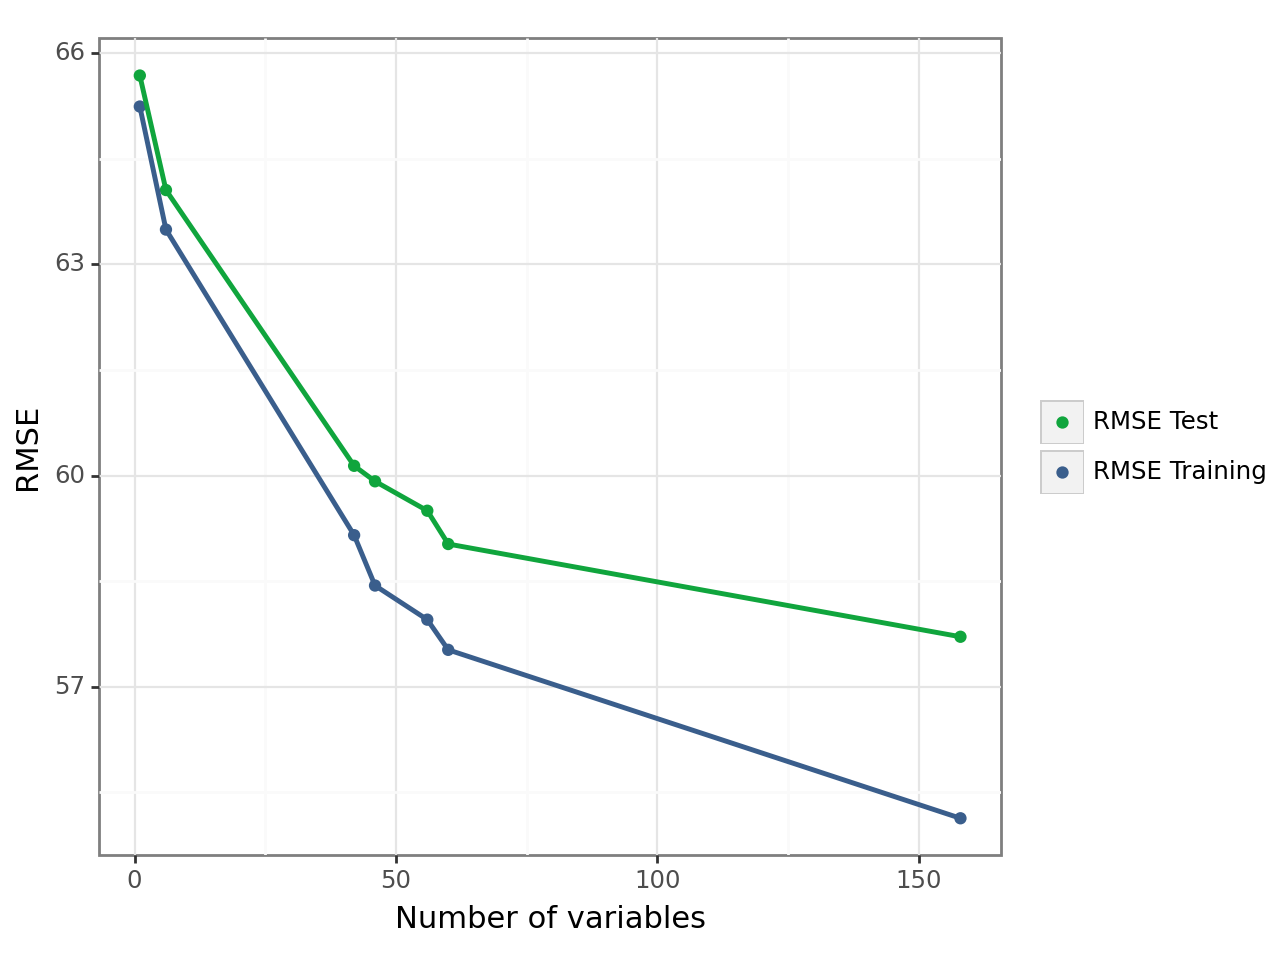

<Figure Size: (640 x 480)>

In [107]:
(
    ggplot(rmse_levels, aes(x="nvars", y="value", color="var"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="RMSE")
    + labs(x="Number of variables")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

# Random FOREST

In [108]:
data_train, data_holdout = train_test_split( listings, train_size=0.8, random_state=42)

In [109]:
data_train.shape, data_holdout.shape

((9132, 142), (2284, 142))

In [110]:
basic_lev = (
    "accommodates",
    "beds",
    "flag_beds",
    "property_type",
    "room_type",
    "bedrooms")

basic_add = ("bathrooms",
             "flag_bathrooms",
             "neighbourhood_cleansed",
             "availability_365",
             "minimum_nights")

reviews = ("number_of_reviews",
           "flag_number_of_reviews",
           "reviews_per_month",
           "flag_reviews_per_month",
           "review_scores_rating",
           "flag_review_scores_rating")

more_reviews = ("review_scores_cleanliness",
                "flag_review_scores_cleanliness",
                "review_scores_checkin",
                "flag_review_scores_checkin",
                "review_scores_communication",
                "flag_review_scores_communication",
                "review_scores_location",
                "flag_review_scores_location",
                "review_scores_value",
                "flag_review_scores_value")

amenity_columns = tuple([col for col in listings.columns if col.startswith("a_")])

In [111]:
predictors_1 = basic_lev
predictors_2 = basic_lev + basic_add
predictors_3 = basic_lev + basic_add + reviews
predictors_4 = basic_lev + basic_add + reviews + more_reviews
predictors_5 = basic_lev + basic_add + reviews + more_reviews + amenity_columns

In [112]:
y, X = dmatrices("price ~ " + " + ".join(predictors_5), data_train)

In [113]:
import math
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 12.69.


In [114]:
y.ravel().shape

(9052,)

In [115]:
rfr = RandomForestRegressor(random_state = 20240129)

In [116]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [117]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [118]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-58.100 total time=   1.0s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-59.463 total time=   0.6s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-57.557 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-57.312 total time=   0.5s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-57.113 total time=   0.5s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-59.311 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-60.344 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-58.799 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-58.411 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-58.340 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-59.959 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=15;, score=-61.075 total time=   0.

In [119]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-57.909044
1,6,10,-59.041215
2,6,15,-59.685578
3,8,5,-57.220559
4,8,10,-58.352901
5,8,15,-58.841388
6,10,5,-56.770223
7,10,10,-57.733046
8,10,15,-58.360854
9,12,5,-56.439283


In [120]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,57.91,59.04,59.69
8,57.22,58.35,58.84
10,56.77,57.73,58.36
12,56.44,57.38,57.96


In [121]:
# best model is 12 max features and 5 min node size
print(rf_model.best_params_)
print(rf_model.best_score_*-1)

{'max_features': 12, 'min_samples_leaf': 5}
56.439282818673725


In [122]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [123]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,bedrooms,9.0%,9.0%
1,accommodates,7.5%,16.6%
2,bathrooms[T.1],6.1%,22.7%
3,beds,5.6%,28.3%
4,bathrooms[T.2],5.4%,33.7%
5,reviews_per_month,3.3%,36.9%
6,review_scores_rating,3.0%,39.9%
7,availability_365[T.3],2.8%,42.7%
8,review_scores_cleanliness,2.3%,45.0%
9,review_scores_location,2.1%,47.1%


# Comparing Results

In [124]:
results_df = pd.DataFrame({"Model":
                           ["Lasso","OLS CV","Random Forest"],
                            "RMSE":
                            [results.best_score_ * -1,rmse_levels[rmse_levels['var'] == 'RMSE Test'].min(axis=0)["value"],rf_model.best_score_*-1]
                            })
results_df.sort_values(by="RMSE")

,Model,RMSE
0,Lasso,56.254903
2,Random Forest,56.439283
1,OLS CV,57.709565
